<a href="https://colab.research.google.com/github/zhou100/FoodSecurityPrediction/blob/master/Predict_FS_recall_smote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use machine learning to predict food security

In [0]:
# Set up Notebook
% matplotlib inline

# Standard imports
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm


# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score

 ## Read in the data cleaned out by R

If you are using google colab like me, you will need to mount your google drive first and  copy the cleaned dataset from the R project to your google drive. 

If you are using python/jupyter notebook locally, just point to the right directory. 

In [0]:
# mw_clust= pd.read_csv("data/clean/dataset/mw_dataset_cluster.csv")

url = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/mw_dataset_cluster.csv'
mw_clust = pd.read_csv(url)

In [0]:
url_tz = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/tz_dataset_cluster.csv'
tz_clust = pd.read_csv(url_tz)

In [166]:
url_ug = 'https://raw.githubusercontent.com/zhou100/FoodSecurityPrediction/master/data/clean/dataset/ug_dataset_cluster.csv'
ug_clust = pd.read_csv(url_ug)
ug_clust = ug_clust.replace([np.inf, -np.inf], np.nan)
ug_clust = ug_clust.dropna()
ug_clust.isnull().values.any()

False

## Preprocessing data


### One-hot encoding for string variables 

In [0]:
mw_clust["FNID"]= mw_clust["FNID"].str.lstrip('MW2012C')
fnid_mw_clust = pd.get_dummies(mw_clust["FNID"],prefix='MW', drop_first=True)
mw_clust = pd.concat([mw_clust, fnid_mw_clust], axis=1)

In [4]:
mw_clust.head()

,FS_year,FNID,FCS,HDDS,rCSI,region_north,region_central,rural,dist_road,dist_admarc,dist_popcenter,percent_ag,nutri_severe_constraint,nutri_moderate_constraint,nutri_reten_severe_constraint,dummy_terrain_rough,FS_month,head_age,female_head,hhsize,floor_dirt_sand_dung,cell_phone,number_celphones,roof_not_natural,roof_iron,asset_index,clust_maize_price,clust_rice_price,clust_nuts_price,clust_beans_price,clust_maize_mktthin,clust_rice_mktthin,clust_nuts_mktthin,clust_beans_mktthin,lhz_maize_price,lhz_rice_price,lhz_nuts_price,lhz_beans_price,lhz_maize_mktthin,lhz_rice_mktthin,...,MW_3020213,MW_3020303,MW_3020403,MW_3020503,MW_3020513,MW_3020515,MW_3020603,MW_3020619,MW_3020703,MW_3020803,MW_3020813,MW_3020815,MW_3020913,MW_3030112,MW_3030114,MW_3030115,MW_3030204,MW_3030206,MW_3030214,MW_3030304,MW_3030306,MW_3030314,MW_3030404,MW_3030414,MW_3030506,MW_3030514,MW_3030519,MW_3030606,MW_3030613,MW_3030714,MW_3030716,MW_3030804,MW_3030816,MW_3030904,MW_3031005,MW_3031105,MW_3031206,MW_3031213,MW_3031313,MW_3999918
0,2010,3010102,42.718750,5.375000,2.750000,1.0,0.0,1.000000,2.656875,12.016250,62.406875,20.875000,0.000000,1.000000,0.0,0,4.000000,45.375000,0.187500,5.937500,0.937500,0.250000,0.437500,0.125000,0.125000,-0.409163,44.282500,247.276000,235.426000,187.412000,0.2,0.0,0.0,0.0,51.144094,194.816929,233.930246,167.089217,0.400000,0.4,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2013,3010102,41.500000,4.687500,11.625000,1.0,0.0,1.000000,2.250000,12.687500,62.562500,23.250000,0.000000,1.000000,0.0,0,4.000000,47.937500,0.250000,6.187500,0.937500,0.250000,0.250000,0.062500,0.062500,-0.587467,117.495000,338.092614,260.726301,169.705691,0.5,1.0,1.0,1.0,145.347005,390.687644,237.306038,271.791314,0.500000,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2010,3010102,35.218750,4.937500,2.687500,1.0,0.0,1.000000,0.513750,10.821875,58.466875,48.687500,0.000000,1.000000,0.0,0,8.000000,43.187500,0.062500,5.437500,0.875000,0.250000,0.250000,0.187500,0.187500,-0.373761,31.591000,176.821000,180.817000,167.261000,0.0,0.0,0.0,0.0,30.082676,141.357511,92.399333,144.797615,1.000000,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2010,3010508,35.218750,4.937500,2.687500,1.0,0.0,1.000000,0.513750,10.821875,58.466875,48.687500,0.000000,1.000000,0.0,0,8.000000,43.187500,0.062500,5.437500,0.875000,0.250000,0.250000,0.187500,0.187500,-0.373761,31.591000,176.821000,180.817000,167.261000,0.0,0.0,0.0,0.0,30.082676,141.357511,92.399333,144.797615,1.000000,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2013,3010102,48.088235,5.058824,2.411765,1.0,0.0,0.941176,0.529412,11.411765,56.529412,45.764706,0.058824,0.941176,0.0,0,5.058824,45.647059,0.176471,5.529412,0.823529,0.411765,0.647059,0.352941,0.352941,-0.322886,119.627402,400.969080,379.379586,347.946196,0.0,1.0,1.0,1.0,96.706535,257.533827,244.449981,231.704856,0.627451,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [103]:
tz_clust.head()

,FS_year,FCS,HDDS,rCSI,rural,FS_month,region2,region3,region4,region5,region6,region7,region8,region9,region10,region11,region12,region13,region14,region15,region16,region17,region18,region19,region20,region21,region51,region52,region53,region54,region55,dist_road,dist_popcenter,percent_ag,nutri_severe_constraint,nutri_moderate_constraint,nutri_reten_severe_constraint,dummy_terrain_rough,head_age,female_head,asset_index,Cellphone,num_cell,floor_dirt_sand_dung,roof_not_natural,roof_iron,clust_maize_price,clust_rice_price,clust_bean_mktthin,clust_maize_mktthin,clust_rice_mktthin,lhz_maize_price,lhz_rice_price,lhz_bean_mktthin,lhz_maize_mktthin,lhz_rice_mktthin,raincytot,day1rain,maxdaysnorain,lhz_day1rain,gdd,tmean,lhz_raincytot,lhz_maxdaysnorain,heatdays,floodmax,lhz_floodmax
0,2015,43.375000,5.250000,6.125,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.464894,32.893617,32.898936,0.606383,0.313830,0.005319,0,41.375000,0.250000,-0.765501,0.625000,0.875000,0.625000,0.625000,0.625000,27708.0,175833.0,0.0,0.0,0.0,44926.970174,175166.466099,0.0,0.0,0.0,949.138410,5,148,81,213,27.410465,701.392269,142,213,0.0,0.0
1,2015,33.562500,4.500000,17.750,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.464894,32.893617,32.898936,0.606383,0.313830,0.005319,0,46.000000,0.125000,-0.886329,0.500000,0.500000,1.000000,0.000000,0.000000,21731.0,161538.0,0.0,0.0,0.0,38137.865269,156000.969581,0.0,0.0,0.0,948.396418,5,117,81,213,27.410465,701.392269,142,213,0.0,0.0
2,2014,34.000000,4.000000,0.000,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.142582,50.944231,23.662088,0.054945,0.708791,0.000000,0,57.000000,0.000000,-0.583524,0.000000,0.000000,1.000000,1.000000,1.000000,34125.0,154166.5,0.0,0.0,0.0,34493.312488,153017.457084,0.0,0.0,0.0,1008.294152,56,154,56,213,23.074113,1057.404969,122,213,0.0,0.0
3,2015,40.642857,4.142857,2.000,1.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.142582,50.944231,23.662088,0.054945,0.708791,0.000000,0,44.428571,0.571429,-0.895485,0.857143,1.285714,0.857143,0.571429,0.571429,33000.0,172778.0,0.0,0.0,0.0,33426.151812,171574.642544,0.0,0.0,0.0,946.519706,5,148,51,213,24.746366,779.541637,125,213,0.0,0.0
4,2015,53.625000,5.000000,9.375,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.661765,70.922549,19.411765,0.009804,0.774510,0.000000,0,50.625000,0.250000,0.050865,1.000000,1.875000,0.125000,1.000000,1.000000,33000.0,172778.0,0.0,0.0,0.0,33000.000000,172778.000000,0.0,0.0,0.0,922.248186,5,117,50,213,24.762482,807.468836,123,213,0.0,0.0


In [171]:
ug_clust['FCS_category']= pd.cut(x=ug_clust['FCS'], bins=[-1,28,42,200],labels= [2, 1, 0])
ug_clust['HDDS_category']= pd.cut(x=ug_clust['HDDS'], bins=[-1,3,6,20],labels= [2, 1, 0])

ug_clust.isnull().values.any()

False

In [172]:
ug_clust.head()

,FS_year,FNID,FCS,HDDS,rural,FS_month,region2,region3,region4,dist_road,dist_popcenter,percent_ag,nutri_severe_constraint,nutri_moderate_constraint,nutri_reten_severe_constraint,dummy_terrain_rough,head_age,female_head,asset_index,Cellphone,num_cell,floor_dirt_sand_dung,roof_not_natural,roof_iron,clust_cassava_price,clust_bean_mktthin,clust_maize_mktthin,clust_cassava_mktthin,lhz_cassava_price,lhz_bean_mktthin,lhz_maize_mktthin,lhz_cassava_mktthin,raincytot,day1rain,maxdaysnorain,lhz_day1rain,gdd,tmean,lhz_raincytot,lhz_maxdaysnorain,floodmax,lhz_floodmax,FCS_category,HDDS_category
0,2010,UG2011L141,47.5,3.0,0.0,12.0,0.0,0.0,0.0,0.81360,4.09120,22.0,0.0,1.0,0.0,0,31.0,0.0,1.933340,1.0,3.0,0.0,1.0,1.0,600.0,1.0,1.0,0.0,593.592838,1.00000,1.00000,0.000000,474.492036,3,28,3,123,25.129216,558.706113,2,0.0,0.0,0,2
1,2011,UG2011L141,20.0,3.0,1.0,1.0,0.0,0.0,0.0,40.43450,65.52810,0.0,0.0,0.0,0.0,0,45.0,0.0,-1.270643,1.0,1.0,1.0,1.0,1.0,900.0,1.0,1.0,0.0,702.971126,1.00000,1.00000,0.028336,1823.754595,3,143,3,488,23.691104,1866.829980,18,0.0,0.0,2,2
2,2012,UG2011L137,52.0,5.4,1.0,4.0,0.0,0.0,0.0,24.63892,48.91718,19.8,0.2,0.2,0.2,0,36.2,0.4,-0.033716,0.8,0.8,0.8,1.0,1.0,1193.6,0.0,0.0,0.0,1197.521782,0.01498,0.01498,0.014980,2040.792751,17,40,14,489,23.937279,1939.734309,24,0.0,0.0,0,1
3,2012,UG2011L140,52.0,5.4,1.0,4.0,0.0,0.0,0.0,24.63892,48.91718,19.8,0.2,0.2,0.2,0,36.2,0.4,-0.033716,0.8,0.8,0.8,1.0,1.0,1193.6,0.0,0.0,0.0,1197.521782,0.01498,0.01498,0.014980,2040.792751,17,40,5,489,23.030044,1967.415063,22,0.0,0.0,0,1
4,2012,UG2011L141,52.0,5.4,1.0,4.0,0.0,0.0,0.0,24.63892,48.91718,19.8,0.2,0.2,0.2,0,36.2,0.4,-0.033716,0.8,0.8,0.8,1.0,1.0,1193.6,0.0,0.0,0.0,1197.521782,0.01498,0.01498,0.014980,2040.792751,17,40,5,489,23.658749,2223.933356,13,0.0,0.0,0,1


In [0]:
ug_clust = ug_clust.drop("FNID",axis =1 )

In [174]:
ug_clust.isnull().values.any()

False

# Methodology


This section will explain our main approach with the data.

1. Focus on categorical prediciton for the given cutoffs. 

Reasons: Close to the actual policy scenarios where we focus on capturing all the insecure households. Recall rate of the insecure villages is more important than the over all accuracy. 

Can apply the down sampling and over sampling technique here to improve 


2.  Algorithms to try : tree classifier, random forest classifier, xgboost 

2.1. By categories, vs one or rest

2.2.  Parameter Tuning

2.3 . feature importance analysis


3.  Error analysis by region, by group, by month

4.  Train model by division separtely Auto-segmentation by training a shallow tree in each country based on observables 

5. Model combination: what happens when we train on all the data 

6. Model generalization issues: what happens when we directly apply  models trained on one country to predict another 







## Exploratory Data Analysis  

### Measures:  plot target measures by year by country


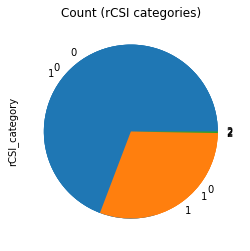

In [185]:
# cut the outcome variables by the cutoffs
mw_clust['FCS_category']= pd.cut(x=mw_clust['FCS'], bins=[-1,28,42,100],labels= [2, 1, 0])
  
mw_clust['FCS_category'].value_counts().plot(kind='pie', title=' Counts (FCS categories)')


 # HDDS 3 and 6
mw_clust['HDDS_category']= pd.cut(x=mw_clust['HDDS'], bins=[0,3,6,10],labels= [2, 1, 0])
  
mw_clust['HDDS_category'].value_counts().plot(kind='pie', title='Count (HDDS categories)')

# rCSI 4 and 17  and 42
mw_clust['rCSI_category']= pd.cut(x=mw_clust['rCSI'], bins=[-1,4,17,42],labels= [0, 1, 2])
  
mw_clust['rCSI_category'].value_counts().plot(kind='pie', title='Count (rCSI categories)')




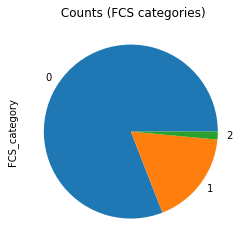

In [175]:
# cut the outcome variables by the cutoffs
tz_clust['FCS_category']= pd.cut(x=tz_clust['FCS'], bins=[-1,28,42,200],labels= [2, 1, 0])

tz_clust['FCS_category'].value_counts().plot(kind='pie', title=' Counts (FCS categories)')


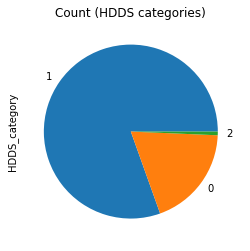

In [176]:
# HDDS 3 and 6
tz_clust['HDDS_category']= pd.cut(x=tz_clust['HDDS'], bins=[-1,3,6,20],labels= [2, 1, 0])

tz_clust['HDDS_category'].value_counts().plot(kind='pie', title='Count (HDDS categories)')


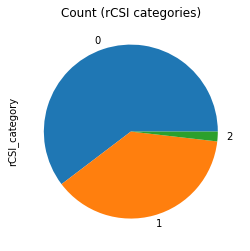

In [177]:
# rCSI 4 and 17  and 42
tz_clust['rCSI_category']= pd.cut(x=tz_clust['rCSI'], bins=[-1,4,17,43],labels= [0, 1, 2])

tz_clust['rCSI_category'].value_counts().plot(kind='pie', title='Count (rCSI categories)')


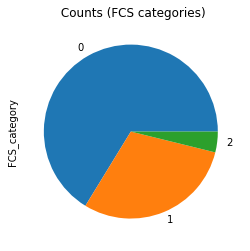

In [178]:
# cut the outcome variables by the cutoffs
ug_clust['FCS_category']= pd.cut(x=ug_clust['FCS'], bins=[-1,28,42,200],labels= [2, 1, 0])

ug_clust['FCS_category'].value_counts().plot(kind='pie', title=' Counts (FCS categories)')




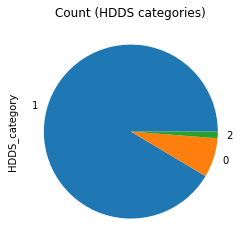

In [179]:
# HDDS 3 and 6
ug_clust['HDDS_category']= pd.cut(x=ug_clust['HDDS'], bins=[-1,3,6,20],labels= [2, 1, 0])

ug_clust['HDDS_category'].value_counts().plot(kind='pie', title='Count (HDDS categories)')

 

### Split train and test data

 For practical prediction purposes,  we use the most recent round of survey data  as the testing  and the rest as the training data. 


In [0]:
# Year split 
mw_clust_test_cond =  mw_clust['FS_year']>2015
mw_clust_train_cond =  mw_clust['FS_year']<2016
mw_clust_test = mw_clust[mw_clust_test_cond]
mw_clust_train = mw_clust[mw_clust_train_cond]


tz_clust_test_cond =  tz_clust['FS_year']>2013
tz_clust_train_cond =  tz_clust['FS_year']<2014
tz_clust_test = tz_clust[tz_clust_test_cond]
tz_clust_train = tz_clust[tz_clust_train_cond]

ug_clust_test_cond =  ug_clust['FS_year']>2011
ug_clust_train_cond =  ug_clust['FS_year']<2012
ug_clust_test = ug_clust[ug_clust_test_cond]
ug_clust_train = ug_clust[ug_clust_train_cond]

In [181]:
ug_clust_train.isnull().values.any()

False

In [183]:
ug_clust_test.isnull().values.any()

False

In [139]:
mw_clust.isnull().values.any()

False

**Separate the target/labels from the X variables. **

In [0]:
labels = ['FCS', 'rCSI', 'HDDS']
category_labels = ['FCS_category', 'rCSI_category', 'HDDS_category']


mw_clust_y_train= mw_clust_train[['FCS_category', 'rCSI_category', 'HDDS_category']]
mw_clust_y_test= mw_clust_test[['FCS_category', 'rCSI_category', 'HDDS_category']]
 
mw_clust_X_test= mw_clust_test.drop(labels+category_labels+['FNID'],  axis=1)
mw_clust_X_train= mw_clust_train.drop(labels+category_labels+['FNID'], axis=1)


tz_clust_y_train= tz_clust_train[['FCS_category', 'rCSI_category', 'HDDS_category']]
tz_clust_y_test= tz_clust_test[['FCS_category', 'rCSI_category', 'HDDS_category']]

tz_clust_X_test= tz_clust_test.drop(labels+category_labels,  axis=1)
tz_clust_X_train= tz_clust_train.drop(labels+category_labels, axis=1)


ug_clust_y_train= ug_clust_train[['FCS_category', 'HDDS_category']]
ug_clust_y_test= ug_clust_test[['FCS_category', 'HDDS_category']]

ug_clust_X_test= ug_clust_test.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],  axis=1)
ug_clust_X_train= ug_clust_train.drop(['FCS_category', 'FCS', 'HDDS', 'HDDS_category'],axis=1)


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


def TreeCLF(X_train,y_train,X_test, y_test):
    # Define tree classifier
    tree_clf = DecisionTreeClassifier(random_state=66)
    
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]
    # n_estimators = [int(x) for x in np.linspace(1, 10, num = 5)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    tree_random = RandomizedSearchCV(estimator = tree_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


    tree_random.fit( X_train, y_train)

    y_pred = tree_random.predict(X_test)
    
    # report = classification_report(y_test, y_pred)

    
    # Return accuracy
    tree_test_score = round(tree_random.score(X_test, y_test), 3)
    tree_train_score = round(tree_random.score(X_train, y_train), 3)
    
    
    
    return y_pred,y_test
    
    # return report

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report


def rfCLF(X_train,y_train,X_test, y_test):

    rf_clf = RandomForestClassifier(max_features='auto', n_estimators = 100,min_samples_split=10,warm_start=True)

        
    # Define rfc classifier
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


    # Fit the random search model
    rf_random.fit(X_train, y_train)

    # Return accuracy
#     rf_test_score = round(rf_random.score(X_test, y_test), 3)
#     rf_train_score = round(rf_random.score(X_train, y_train), 3)
    
    y_pred = rf_random.predict(X_test)
    

    # return rf_test_score 
    return y_pred,y_test

In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report


def XGBCLF(X_train,y_train,X_test, y_test):

    # fit model on  training data
    XGB_clf = XGBClassifier(silent=False, 
                          scale_pos_weight=1,
                          learning_rate=0.3,  
                          colsample_bytree = 0.4,
                          subsample = 0.8,
                          objective='binary:logistic', 
                          #objective='multi:softmax', 
                          #num_class=14,
                          n_estimators=100, 
                          reg_alpha = 0.3,
                          max_depth=5, 
                          gamma=10)
    
    max_depth = [int(x) for x in np.linspace(3, 20, num = 10)]
    max_features = [int(x) for x in np.linspace(3, 20, num = 10)]

    random_grid = {#'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth
                   #'min_samples_split': min_samples_split
                   #'min_samples_leaf': min_samples_leaf}
                   #'bootstrap': bootstrap
                    }
    
    XGB_random = RandomizedSearchCV(estimator = XGB_clf, param_distributions = random_grid,
                                    n_iter = 30, cv = 3, verbose=2, random_state=666, n_jobs = -1)


    
    # Fit the random search model
    XGB_random.fit(X_train, y_train)

    # Return accuracy
    xgb_test_score = round(XGB_random.score(X_test, y_test), 3)
    xgb_train_score = round(XGB_random.score(X_train, y_train), 3)
    
    # return xgb_test_score
    
    y_pred = XGB_random.predict(X_test)
    

    # return rf_test_score 
    return y_pred,y_test


In [13]:
mw_clust_y_train['FCS_category'].value_counts()

0    1699
1     461
2      14
Name: FCS_category, dtype: int64

In [191]:
y_pred,y_test = TreeCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.70      1.00      0.82       309
           1       0.83      0.04      0.07       136

    accuracy                           0.70       445
   macro avg       0.77      0.52      0.45       445
weighted avg       0.74      0.70      0.59       445



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.6s finished


In [36]:
y_pred,y_test  = TreeCLF (mw_clust_X_train,mw_clust_y_train['HDDS_category'], mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.49      0.66       445

    accuracy                           0.49       445
   macro avg       0.50      0.24      0.33       445
weighted avg       1.00      0.49      0.66       445



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.1s finished


In [37]:
y_pred,y_test  = TreeCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.33      0.69      0.45       157
           1       0.55      0.23      0.33       282
           2       0.00      0.00      0.00         6

    accuracy                           0.39       445
   macro avg       0.30      0.31      0.26       445
weighted avg       0.47      0.39      0.37       445



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished


In [43]:
y_pred,y_test  =  rfCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.0s finished


              precision    recall  f1-score   support

           0       0.69      1.00      0.82       309
           1       0.00      0.00      0.00       136

    accuracy                           0.69       445
   macro avg       0.35      0.50      0.41       445
weighted avg       0.48      0.69      0.57       445



In [46]:
y_pred,y_test  = rfCLF (mw_clust_X_train,mw_clust_y_train['HDDS_category'], mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   16.6s finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.67      0.80       445

    accuracy                           0.67       445
   macro avg       0.50      0.34      0.40       445
weighted avg       1.00      0.67      0.80       445



In [47]:
y_pred,y_test  =  rfCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   19.0s finished


              precision    recall  f1-score   support

           0       0.39      0.93      0.55       157
           1       0.78      0.20      0.32       282
           2       0.00      0.00      0.00         6

    accuracy                           0.45       445
   macro avg       0.39      0.38      0.29       445
weighted avg       0.63      0.45      0.39       445



In [50]:
y_pred,y_test  = XGBCLF (mw_clust_X_train,mw_clust_y_train['FCS_category'], mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.7min finished


              precision    recall  f1-score   support

           0       0.69      1.00      0.82       309
           1       0.00      0.00      0.00       136

    accuracy                           0.69       445
   macro avg       0.35      0.50      0.41       445
weighted avg       0.48      0.69      0.57       445



In [51]:
y_pred,y_test  =  XGBCLF (mw_clust_X_train,mw_clust_y_train['HDDS_category'], mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.66      0.79       445

    accuracy                           0.66       445
   macro avg       0.50      0.33      0.40       445
weighted avg       1.00      0.66      0.79       445



In [52]:
y_pred,y_test  =  XGBCLF (mw_clust_X_train,mw_clust_y_train['rCSI_category'], mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


              precision    recall  f1-score   support

           0       0.59      0.55      0.57       157
           1       0.74      0.79      0.77       282
           2       0.00      0.00      0.00         6

    accuracy                           0.69       445
   macro avg       0.45      0.45      0.45       445
weighted avg       0.68      0.69      0.69       445



In [192]:
y_pred,y_test = TreeCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = TreeCLF (tz_clust_X_train,tz_clust_y_train['HDDS_category'], tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = TreeCLF (tz_clust_X_train,tz_clust_y_train['rCSI_category'], tz_clust_X_test,tz_clust_y_test['rCSI_category'] )
print(classification_report(y_test, y_pred))


y_pred,y_test  =  rfCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )
print(classification_report(y_test, y_pred))

y_pred,y_test  = rfCLF (tz_clust_X_train,tz_clust_y_train['HDDS_category'], tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  =  rfCLF (tz_clust_X_train,tz_clust_y_train['rCSI_category'], tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  = XGBCLF (tz_clust_X_train,tz_clust_y_train['FCS_category'], tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  =  XGBCLF (tz_clust_X_train,tz_clust_y_train['HDDS_category'], tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  =  XGBCLF (tz_clust_X_train,tz_clust_y_train['rCSI_category'], tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       342
           1       0.50      0.02      0.04        43
           2       0.00      0.00      0.00         1

    accuracy                           0.89       386
   macro avg       0.46      0.34      0.33       386
weighted avg       0.84      0.89      0.84       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.50      0.02      0.05        82
           1       0.79      0.99      0.88       304

    accuracy                           0.79       386
   macro avg       0.65      0.51      0.46       386
weighted avg       0.73      0.79      0.70       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.65      0.83      0.73       227
           1       0.58      0.37      0.45       153
           2       0.00      0.00      0.00         6

    accuracy                           0.63       386
   macro avg       0.41      0.40      0.39       386
weighted avg       0.61      0.63      0.61       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.1s finished


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       342
           1       0.00      0.00      0.00        43
           2       0.00      0.00      0.00         1

    accuracy                           0.89       386
   macro avg       0.30      0.33      0.31       386
weighted avg       0.79      0.89      0.83       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        82
           1       0.79      1.00      0.88       304

    accuracy                           0.79       386
   macro avg       0.39      0.50      0.44       386
weighted avg       0.62      0.79      0.69       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   22.9s finished


              precision    recall  f1-score   support

           0       0.64      0.88      0.74       227
           1       0.57      0.28      0.38       153
           2       0.00      0.00      0.00         6

    accuracy                           0.63       386
   macro avg       0.40      0.39      0.37       386
weighted avg       0.60      0.63      0.58       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.3min finished


              precision    recall  f1-score   support

           0       0.91      0.96      0.93       342
           1       0.41      0.21      0.28        43
           2       0.00      0.00      0.00         1

    accuracy                           0.88       386
   macro avg       0.44      0.39      0.40       386
weighted avg       0.85      0.88      0.86       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.2min finished


              precision    recall  f1-score   support

           0       0.58      0.23      0.33        82
           1       0.82      0.95      0.88       304

    accuracy                           0.80       386
   macro avg       0.70      0.59      0.61       386
weighted avg       0.77      0.80      0.77       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.4min finished


              precision    recall  f1-score   support

           0       0.65      0.81      0.73       227
           1       0.56      0.38      0.45       153
           2       0.00      0.00      0.00         6

    accuracy                           0.63       386
   macro avg       0.41      0.40      0.39       386
weighted avg       0.61      0.63      0.61       386



In [193]:
y_pred,y_test = TreeCLF (ug_clust_X_train,ug_clust_y_train['FCS_category'], ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = TreeCLF (ug_clust_X_train,ug_clust_y_train['HDDS_category'], ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  =  rfCLF (ug_clust_X_train,ug_clust_y_train['FCS_category'], ug_clust_X_test,ug_clust_y_test['FCS_category'] )
print(classification_report(y_test, y_pred))

y_pred,y_test  = rfCLF (ug_clust_X_train,ug_clust_y_train['HDDS_category'], ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))



y_pred,y_test  = XGBCLF (ug_clust_X_train,ug_clust_y_train['FCS_category'], ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))


y_pred,y_test  =  XGBCLF (ug_clust_X_train,ug_clust_y_train['HDDS_category'], ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))



Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.82      0.86      0.84       334
           1       0.42      0.37      0.39        97
           2       1.00      0.11      0.20         9

    accuracy                           0.74       440
   macro avg       0.74      0.45      0.48       440
weighted avg       0.73      0.74      0.73       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.88      1.00      0.94       389
           2       0.00      0.00      0.00         2

    accuracy                           0.88       440
   macro avg       0.29      0.33      0.31       440
weighted avg       0.78      0.88      0.83       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.80      0.96      0.87       334
           1       0.46      0.16      0.24        97
           2       0.00      0.00      0.00         9

    accuracy                           0.77       440
   macro avg       0.42      0.38      0.37       440
weighted avg       0.70      0.77      0.71       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   12.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.88      1.00      0.94       389
           2       0.00      0.00      0.00         2

    accuracy                           0.88       440
   macro avg       0.29      0.33      0.31       440
weighted avg       0.78      0.88      0.83       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   26.6s finished


              precision    recall  f1-score   support

           0       0.78      0.96      0.86       334
           1       0.41      0.12      0.19        97
           2       0.00      0.00      0.00         9

    accuracy                           0.76       440
   macro avg       0.40      0.36      0.35       440
weighted avg       0.69      0.76      0.70       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   18.9s finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        49
           1       0.88      1.00      0.94       389
           2       0.00      0.00      0.00         2

    accuracy                           0.88       440
   macro avg       0.29      0.33      0.31       440
weighted avg       0.78      0.88      0.83       440



In [86]:
ug_clust_y_train.isnull().values.any()

True

In [90]:
tz_clust_X_train.isnull().values.any()

False

### downsample / oversample 

Using simpler metrics like accuracy_score can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate, obviously illusory.

Resampling
A widely adopted technique for dealing with highly unbalanced datasets is called resampling. It consists of removing samples from the majority class (under-sampling) and / or adding more examples from the minority class (over-sampling).

Despite the advantage of balancing classes, these techniques also have their weaknesses (there is no free lunch). The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.



In [0]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([mw_clust_X_train, mw_clust_y_train['rCSI_category']], axis=1)


not_crisis = X[X.rCSI_category==0]
crisis = X[X.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
crisis_upsampled = resample(crisis,
                          replace=True, # sample with replacement
                          n_samples=len(not_crisis), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_crisis, crisis_upsampled])

upsampled_y_train = upsampled["rCSI_category"]

upsampled_X_train = upsampled.drop("rCSI_category",axis=1)

In [212]:
y_pred,y_test  = rfCLF (upsampled_X_train,upsampled_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.4s finished


              precision    recall  f1-score   support

           0       0.42      0.87      0.56       157
           1       0.77      0.32      0.45       282
           2       0.00      0.00      0.00         6

    accuracy                           0.51       445
   macro avg       0.40      0.40      0.34       445
weighted avg       0.64      0.51      0.48       445



In [213]:
y_pred,y_test  = XGBCLF (upsampled_X_train,upsampled_y_train, mw_clust_X_test,mw_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


              precision    recall  f1-score   support

           0       0.62      0.56      0.59       157
           1       0.75      0.80      0.78       282
           2       0.00      0.00      0.00         6

    accuracy                           0.71       445
   macro avg       0.46      0.46      0.45       445
weighted avg       0.69      0.71      0.70       445



In [215]:
from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([mw_clust_X_train, mw_clust_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                          replace=True, # sample with replacement
                          n_samples=len(HDDS_not_crisis), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (upsampled_X_train,upsampled_y_train, mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (upsampled_X_train,upsampled_y_train, mw_clust_X_test,mw_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.3s finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.13      0.23       445

    accuracy                           0.13       445
   macro avg       0.50      0.07      0.12       445
weighted avg       1.00      0.13      0.23       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.68      0.81       445

    accuracy                           0.68       445
   macro avg       0.50      0.34      0.40       445
weighted avg       1.00      0.68      0.81       445



In [216]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([mw_clust_X_train, mw_clust_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(FCS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (upsampled_X_train,upsampled_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (upsampled_X_train,upsampled_y_train, mw_clust_X_test,mw_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   24.4s finished


              precision    recall  f1-score   support

           0       0.80      0.95      0.87       309
           1       0.82      0.46      0.59       136

    accuracy                           0.80       445
   macro avg       0.81      0.71      0.73       445
weighted avg       0.81      0.80      0.79       445

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.5min finished


              precision    recall  f1-score   support

           0       0.94      0.43      0.59       309
           1       0.42      0.93      0.58       136

    accuracy                           0.59       445
   macro avg       0.68      0.68      0.59       445
weighted avg       0.78      0.59      0.59       445



In [219]:
from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([tz_clust_X_train, tz_clust_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                 replace=True, # sample with replacement
                                 n_samples=len(HDDS_not_crisis), # match number in majority class
                                 random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))






Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   13.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.40      0.84      0.55        82
           1       0.94      0.66      0.78       304

    accuracy                           0.70       386
   macro avg       0.67      0.75      0.66       386
weighted avg       0.83      0.70      0.73       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   29.4s finished


              precision    recall  f1-score   support

           0       0.40      0.84      0.54        82
           1       0.94      0.65      0.77       304

    accuracy                           0.69       386
   macro avg       0.67      0.75      0.66       386
weighted avg       0.82      0.69      0.72       386



In [220]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([tz_clust_X_train, tz_clust_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   29.7s finished


              precision    recall  f1-score   support

           0       0.93      0.92      0.92       342
           1       0.39      0.44      0.41        43
           2       0.00      0.00      0.00         1

    accuracy                           0.86       386
   macro avg       0.44      0.45      0.44       386
weighted avg       0.87      0.86      0.86       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


              precision    recall  f1-score   support

           0       0.95      0.83      0.89       342
           1       0.32      0.63      0.42        43
           2       0.00      0.00      0.00         1

    accuracy                           0.81       386
   macro avg       0.42      0.49      0.44       386
weighted avg       0.87      0.81      0.83       386



In [221]:
from sklearn.utils import resample

# concatenate our training data back together
rCSI_df = pd.concat([tz_clust_X_train, tz_clust_y_train['rCSI_category']], axis=1)


rCSI_not_crisis = rCSI_df[rCSI_df.rCSI_category==0]
rCSI_crisis = rCSI_df[rCSI_df.rCSI_category!=0]

# separate minority and majority classes

# upsample minority
rCSI_crisis_upsampled = resample(rCSI_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(rCSI_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
rCSI_upsampled = pd.concat([rCSI_not_crisis, rCSI_crisis_upsampled])

rCSI_upsampled_y_train = rCSI_upsampled["rCSI_category"]

rCSI_upsampled_X_train = rCSI_upsampled.drop("rCSI_category",axis=1)

y_pred,y_test  = rfCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (rCSI_upsampled_X_train,rCSI_upsampled_y_train, tz_clust_X_test,tz_clust_y_test['rCSI_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   25.5s finished


              precision    recall  f1-score   support

           0       0.66      0.78      0.72       227
           1       0.55      0.43      0.49       153
           2       0.00      0.00      0.00         6

    accuracy                           0.63       386
   macro avg       0.41      0.40      0.40       386
weighted avg       0.61      0.63      0.61       386

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  1.7min finished


              precision    recall  f1-score   support

           0       0.66      0.74      0.70       227
           1       0.52      0.44      0.48       153
           2       0.00      0.00      0.00         6

    accuracy                           0.61       386
   macro avg       0.39      0.39      0.39       386
weighted avg       0.59      0.61      0.60       386



In [222]:
from sklearn.utils import resample

# concatenate our training data back together
FCS_df = pd.concat([ug_clust_X_train, ug_clust_y_train['FCS_category']], axis=1)


FCS_not_crisis = FCS_df[FCS_df.FCS_category==0]
FCS_crisis = FCS_df[FCS_df.FCS_category!=0]

# separate minority and majority classes

# upsample minority
FCS_crisis_upsampled = resample(FCS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(FCS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
FCS_upsampled = pd.concat([FCS_not_crisis, FCS_crisis_upsampled])

FCS_upsampled_y_train = FCS_upsampled["FCS_category"]

FCS_upsampled_X_train = FCS_upsampled.drop("FCS_category",axis=1)

y_pred,y_test  = rfCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (FCS_upsampled_X_train,FCS_upsampled_y_train, ug_clust_X_test,ug_clust_y_test['FCS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   14.3s finished


              precision    recall  f1-score   support

           0       0.80      0.94      0.87       334
           1       0.44      0.21      0.28        97
           2       1.00      0.11      0.20         9

    accuracy                           0.76       440
   macro avg       0.75      0.42      0.45       440
weighted avg       0.73      0.76      0.72       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   32.7s finished


              precision    recall  f1-score   support

           0       0.80      0.93      0.86       334
           1       0.42      0.24      0.30        97
           2       0.00      0.00      0.00         9

    accuracy                           0.75       440
   macro avg       0.41      0.39      0.39       440
weighted avg       0.70      0.75      0.72       440



In [224]:
from sklearn.utils import resample

# concatenate our training data back together
HDDS_df = pd.concat([ug_clust_X_train, ug_clust_y_train['HDDS_category']], axis=1)


HDDS_not_crisis = HDDS_df[HDDS_df.HDDS_category==0]
HDDS_crisis = HDDS_df[HDDS_df.HDDS_category!=0]

# separate minority and majority classes

# upsample minority
HDDS_crisis_upsampled = resample(HDDS_crisis,
                                replace=True, # sample with replacement
                                n_samples=len(HDDS_not_crisis), # match number in majority class
                                random_state=27) # reproducible results

# combine majority and upsampled minority
HDDS_upsampled = pd.concat([HDDS_not_crisis, HDDS_crisis_upsampled])

HDDS_upsampled_y_train = HDDS_upsampled["HDDS_category"]

HDDS_upsampled_X_train = HDDS_upsampled.drop("HDDS_category",axis=1)

y_pred,y_test  = rfCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

y_pred,y_test  = XGBCLF (HDDS_upsampled_X_train,HDDS_upsampled_y_train, ug_clust_X_test,ug_clust_y_test['HDDS_category'] )

print(classification_report(y_test, y_pred))

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    6.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


              precision    recall  f1-score   support

           0       0.37      0.51      0.43        49
           1       0.93      0.89      0.91       389
           2       0.00      0.00      0.00         2

    accuracy                           0.85       440
   macro avg       0.43      0.47      0.45       440
weighted avg       0.86      0.85      0.85       440

Fitting 3 folds for each of 30 candidates, totalling 90 fits
              precision    recall  f1-score   support

           0       0.23      0.73      0.35        49
           1       0.95      0.69      0.80       389
           2       0.00      0.00      0.00         2

    accuracy                           0.69       440
   macro avg       0.39      0.48      0.38       440
weighted avg       0.86      0.69      0.75       440



[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    3.1s finished


In [0]:
import imblearn

from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

sm = SMOTE(random_state=27, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train
                                )

smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)

smote_pred = smote.predict(X_test)



For example, we can cluster the records of the majority class, and do the under-sampling by removing records from each cluster, thus seeking to preserve information. In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.

Let's apply some of these resampling techniques, using the Python library imbalanced-learn. It is compatible with scikit-learn and is part of scikit-learn-contrib projects.

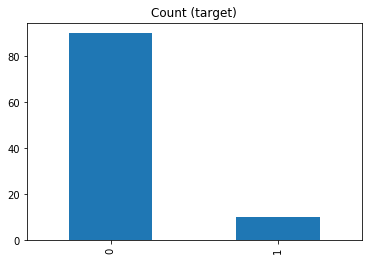

In [0]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_classes=2, class_sep=1.5, weights=[0.9, 0.1],
    n_informative=3, n_redundant=1, flip_y=0,
    n_features=20, n_clusters_per_class=1,
    n_samples=100, random_state=10
)

df = pd.DataFrame(X)
df['target'] = y
df.target.value_counts().plot(kind='bar', title='Count (target)');


In [0]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)

print(X_ros.shape[0] - X.shape[0], 'new random picked points')

plot_2d_space(X_ros, y_ros, 'Random over-sampling')

In [0]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, ratio='majority')
X_tl, y_tl, id_tl = tl.fit_sample(X, y)

print('Removed indexes:', id_tl)

plot_2d_space(X_tl, y_tl, 'Tomek links under-sampling')

In [0]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(X, y)

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

In [0]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(X, y)

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

Under-sampling: Tomek links
Tomek links are pairs of very close instances, but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

In [0]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))


In [0]:
# confusion matrix , focus on improving the recall rate of the insecure class



In [0]:
# One vs all and plot the AUC ( )

### Models

#### Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression

def fit_linear(X_train, X_test,y_train,y_test):

    # Create and fit our linear regression model to training data
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)

    # Compute model predictions for test data
    pred = model.predict(X_test)

    r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
    return r2

# implement the algorithm and present results
result_table(function=fit_linear)

NameError: ignored

#### Ridge

In [0]:
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import RandomizedSearchCV


def fit_ridge(X_train, X_test,y_train,y_test):

  model = RidgeCV(alphas=[0.0, 1E-6, 1E-4, 1E-2, 1.0], fit_intercept=True, normalize=True, scoring=None, cv=5, gcv_mode='auto', store_cv_values=False) 

# Define different alpha values for different fits
# alpha = [0.0, 1E-6, 1E-4, 1E-2, 1.0]

  model.fit(X_train, y_train)

  # Compute model predictions for test data
  pred = model.predict(X_test)

  r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
  return r2



# implement the algorithm and present results
result_table(function=fit_ridge)

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.265,0.270,0.110
1,Malawi_cluster,0.431,0.642,0.217
2,Tanzania_household,0.048,0.006,0.015
3,Tanzania_cluster,0.153,0.020,0.087
4,Uganda_household,0.179,0.219,0.000
5,Uganda_cluster,0.365,0.421,0.000


In [0]:
from sklearn.linear_model import LassoCV

def fit_lasso(X_train, X_test,y_train,y_test):

    model = LassoCV(eps=0.001, n_alphas=100, alphas=(0.01, 2), fit_intercept=True,precompute='auto',n_jobs=4, random_state=0, selection='cyclic')

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)

    r2= stats.pearsonr(y_test, pred)[0] ** 2
    return r2

  
# implement the algorithm and present results
result_table(function=fit_lasso)

NameError: ignored

In [0]:
from sklearn.linear_model import ElasticNetCV

def fit_en(X_train, X_test,y_train,y_test):


    model = ElasticNetCV(alphas=(0.1,0.02,3,2), copy_X=True, cv=10, eps=0.004, fit_intercept=True,
           l1_ratio=0.33, max_iter=1000, n_alphas=100, n_jobs=1,
           normalize=False, positive=False, precompute='auto', random_state=0,
           selection='cyclic', tol=0.0001, verbose=0)

    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)

    r2= stats.pearsonr(y_test, pred)[0] ** 2
    
    return r2


# implement the algorithm and present results
result_table(function=fit_en)    
    

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.377,0.259,0.094
1,Malawi_cluster,0.683,0.587,0.192
2,Tanzania_household,0.048,0.005,0.015
3,Tanzania_cluster,0.153,0.020,0.088
4,Uganda_household,0.141,0.219,0.000
5,Uganda_cluster,0.264,0.387,0.000


In [0]:
from sklearn.ensemble import RandomForestRegressor

def fit_rfc(X_train, X_test,y_train,y_test):
  # Create Regressor with default properties
  rfc = RandomForestRegressor(random_state =0,n_jobs =4,warm_start = True,max_depth=4, min_samples_leaf=5 )
  
  
  parameters = {'max_depth':np.arange( 1,4, 1 ).tolist(), 'min_samples_leaf':np.arange( 1, 4, 1 ).tolist()}
  model = GridSearchCV(rfc, parameters,cv=6, n_jobs= 4, iid = True,  refit= True,pre_dispatch= '2*n_jobs')

  model.fit(X_train,y_train)
  # Fit estimator and display score

  # Regress on test data
  pred = model.predict(X_test)

  r2 = stats.pearsonr(y_test, pred)[0] ** 2
    
  return r2

result_table(function=fit_rfc)

,dataset,FCS,HDDS,rCSI
0,Malawi_household,0.369,0.269,0.115
1,Malawi_cluster,0.713,0.706,0.267
2,Tanzania_household,0.195,0.221,0.048
3,Tanzania_cluster,0.289,0.385,0.127
4,Uganda_household,0.172,0.189,0.000
5,Uganda_cluster,0.314,0.435,0.000


In [0]:
from sklearn.ensemble import GradientBoostingRegressor

# Create Regressor with default properties
gbr = GradientBoostingRegressor(random_state=0,learning_rate=0.4, n_estimators=9,subsample=1, criterion='friedman_mse', min_samples_split=2)

gbr.fit(x_train, y_train_new)
pred = gbr.predict(x_test)

actual =y_test_new
r2_gbr= stats.pearsonr(actual, pred)[0] ** 2
r2_gbr

In [0]:
from sklearn.gaussian_process import  GaussianProcessRegressor

# Import our kernels
from sklearn.gaussian_process.kernels import Matern, WhiteKernel



# Define custom kernel (Matern + noise)
krnl = 2. + Matern(length_scale=1, nu=1.8) + WhiteKernel(noise_level=10)

# Create Regressor with specified properties
gpr = GaussianProcessRegressor(kernel=krnl, random_state=23)

# Fit estimator and display score
gpr= gpr.fit(x_train, y_train[labels[0]])
pred = gpr.predict(x_test)
actual = y_test[labels[0]]
r2_gpr= stats.pearsonr(actual, pred)[0] ** 2
r2_gpr

pd = {'svc__C': st.uniform(0, 250),
      'svc__gamma': g_vals}
 
# Run randomized search
rscv = RandomizedSearchCV(svp, param_distributions=pd,
                          n_iter=num_samples)

## Visualization

In [0]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].scatter( actual_linear,pred_linear)
axs[0, 0].plot(actual_linear,actual_linear, color='red')

axs[1, 0].scatter( actual_rfr, pred_rfr)
axs[1, 0].plot(actual_rfr, actual_rfr, color='red')


axs[0, 1].scatter(actual_en ,pred_en )
axs[0, 1].plot(actual_en,actual_en, color='red')

axs[1, 1].scatter(actual_gbr, pred_gbr )
axs[1, 1].plot(actual_gbr, actual_gbr, color='red')


axs[0, 0].title.set_text('Scatter Plot Linear')
axs[1, 0].title.set_text('Scatter Plot RandomForest')
axs[0, 1].title.set_text('Scatter Plot ElasticNet')
axs[1, 1].title.set_text('Scatter Plot GradientBoosting')
plt.show()

## Interpretation


Hit and misses 

expand the prediction to grid level 